## Section 1: Imports and Reading Data

In [1]:
# Imports
import numpy as np
import pandas as pd
import transformers
from transformers import BertModel
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

2023-11-28 19:02:16.543889: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-28 19:02:16.543927: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-28 19:02:16.545206: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-28 19:02:16.552409: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-28 19:02:17.844880: W tensorflow/compiler/tf2

In [2]:
# Reading Data
df = pd.read_csv("data.csv")
encoder = LabelEncoder()
labels = encoder.fit_transform(df.Sentiment)

## Section 2: Preprocessing and Tokenization

In [3]:
# Remove rows with null values
df = df.dropna()

# Tokenization
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
X_train, X_test, y_train, y_test = train_test_split(df.Sentence.values, labels, test_size=0.2, stratify=df.Sentiment.values)

In [4]:
# Section 3: Dataset Class

In [5]:
# Dataset Class
class Datagen(Dataset):
    def __init__(self, sentence, target, tokenizer, max_len):
        self.sentence = sentence
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.sentence)

    def __getitem__(self, idx):
        sentence = self.sentence[idx]
        bert_encoding = tokenizer.encode_plus(
            sentence,
            max_length=self.max_len,
            add_special_tokens=True,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )
        return {
            "input_ids": torch.squeeze(bert_encoding["input_ids"]),
            "attention_mask": torch.squeeze(bert_encoding["attention_mask"]),
            "target": torch.tensor(self.target[idx], dtype=torch.long)
        }


In [6]:
# Section 4: TensorBoard Configuration and Model Parameters

In [7]:
# TensorBoard Configuration
writer = SummaryWriter()

class SentimentModel(nn.Module):
    def __init__(self, n_class):
        super(SentimentModel, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.drop = nn.Dropout(0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_class)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(input_ids, attention_mask, return_dict=False)
        output = self.drop(pooled_output)
        output = self.out(output)
        return self.softmax(output)

model = SentimentModel(n_class=3)
model = model.to(torch.device('cuda'))
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, 'min')


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
# Section 5: Helper Functions

In [9]:
def check_acc(preds, labels):
    correct = 0
    for pred, label in zip(preds, labels):
        if pred == label:
            correct += 1
    return correct/len(preds)

def accuracy(dataloader, model):
    model.eval()
    batch_acc = 0
    for inputs in dataloader:
        to_cuda = lambda x: x.to(torch.device('cuda'), non_blocking=True).long()
        input_ids, attention_mask, target = list(map(to_cuda, inputs.values()))

        outputs = model(input_ids, attention_mask)
        prediction = outputs.argmax(dim=1)
        acc = check_acc(prediction, target)
        batch_acc += acc
    return batch_acc/len(dataloader)


In [10]:
# Section 6: Training with Cross-Validation

In [11]:
num_epochs = 5
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(skf.split(df.Sentence.values, labels)):
    print(f"Fold {fold + 1}/{skf.get_n_splits()}")

    X_train, X_temp = df.Sentence.values[train_index], df.Sentence.values[test_index]
    y_train, y_temp = labels[train_index], labels[test_index]

    # Further split the test set into cv and test
    X_cv, X_test, y_cv, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)

    train_data = Datagen(X_train, y_train, tokenizer, 50)
    cv_data = Datagen(X_cv, y_cv, tokenizer, 50)
    test_data = Datagen(X_test, y_test, tokenizer, 50)

    train_dataloader = DataLoader(train_data, batch_size=16, num_workers=2)
    cv_dataloader = DataLoader(cv_data, batch_size=15, num_workers=2)
    test_dataloader = DataLoader(test_data, batch_size=15, num_workers=2)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for steps, inputs in enumerate(train_dataloader):
            to_cuda = lambda x: x.to(torch.device('cuda'), non_blocking=True).long()
            input_ids, attention_mask, target = list(map(to_cuda, inputs.values()))
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        average_loss = total_loss / len(train_dataloader)
        writer.add_scalar(f"Train/Average_Loss_Fold{fold}", average_loss, epoch)

        train_acc = accuracy(train_dataloader, model)
        cv_acc = accuracy(cv_dataloader, model)

        print(f"Fold {fold + 1}/{skf.get_n_splits()}\t Epoch: {epoch}\t Train accuracy: {train_acc}\t CV accuracy: {cv_acc}")

        writer.add_scalar(f"Train/Accuracy_Fold{fold}", train_acc, epoch)
        writer.add_scalar(f"CV/Accuracy_Fold{fold}", cv_acc, epoch)

        scheduler.step(average_loss) 

Fold 1/5
Fold 1/5	 Epoch: 0	 Train accuracy: 0.8148464163822525	 CV accuracy: 0.7708180708180711
Fold 1/5	 Epoch: 1	 Train accuracy: 0.830844709897611	 CV accuracy: 0.7315018315018318
Fold 1/5	 Epoch: 2	 Train accuracy: 0.8602815699658704	 CV accuracy: 0.7399267399267402
Fold 1/5	 Epoch: 3	 Train accuracy: 0.8656143344709898	 CV accuracy: 0.7228327228327232
Fold 1/5	 Epoch: 4	 Train accuracy: 0.8822525597269625	 CV accuracy: 0.7330891330891336
Fold 2/5
Fold 2/5	 Epoch: 0	 Train accuracy: 0.8511092150170648	 CV accuracy: 0.8698412698412701
Fold 2/5	 Epoch: 1	 Train accuracy: 0.859641638225256	 CV accuracy: 0.8612942612942616
Fold 2/5	 Epoch: 2	 Train accuracy: 0.8540955631399317	 CV accuracy: 0.8509157509157514
Fold 2/5	 Epoch: 3	 Train accuracy: 0.8647610921501706	 CV accuracy: 0.8732600732600735
Fold 2/5	 Epoch: 4	 Train accuracy: 0.869240614334471	 CV accuracy: 0.857875457875458
Fold 3/5
Fold 3/5	 Epoch: 0	 Train accuracy: 0.8585750853242321	 CV accuracy: 0.876800976800977
Fold 3/5	 

Test accuracy: 0.8749694749694751
              precision    recall  f1-score   support

           0       0.81      0.41      0.54        86
           1       0.85      0.95      0.90       313
           2       0.93      0.97      0.95       185

    accuracy                           0.88       584
   macro avg       0.87      0.77      0.80       584
weighted avg       0.87      0.88      0.86       584


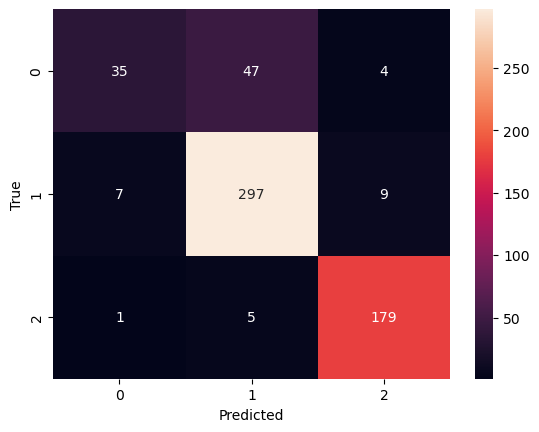

In [14]:
# Testing
model.eval()
test_acc = accuracy(test_dataloader, model)
print(f"Test accuracy: {test_acc}")

# Metrics for classification, use this to get precision, recall, f2 from sklearn.metrics import classification_report, using cpu.
from sklearn.metrics import classification_report

y_pred = []
y_true = []
for inputs in test_dataloader:
    to_cuda = lambda x: x.to(torch.device('cuda'), non_blocking=True).long()
    input_ids, attention_mask, target = list(map(to_cuda, inputs.values()))

    outputs = model(input_ids, attention_mask)
    prediction = outputs.argmax(dim=1)
    y_pred.extend(prediction.cpu().numpy())
    y_true.extend(target.cpu().numpy())
    
print(classification_report(y_true, y_pred))
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [15]:
# Saving the model
torch.save(model.state_dict(), "model_otp.pt")

In [ ]:
# Plotting Confusion Matrix